In [1]:
import numpy as np
import os
import sys
import copy

import torch
from torch import nn

import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy
import scipy.io

np.random.seed(123)

In [2]:
#name = "Compare_depth"
#name = "Compare_batch"
#name = "Compare_final_kernel_size"
#name = "Compare_channels"
name = "Compare_lw_noise"

if name == "Compare_depth":
    
    mods = ["Ensemble_PIPNet_2022_02_01_1_layers", "Ensemble_PIPNet_2022_02_01_2_layers",
            "Ensemble_PIPNet_2022_02_01_3_layers", "Ensemble_PIPNet_2022_02_01_4_layers",
            "Ensemble_PIPNet_2022_02_01_5_layers", "Ensemble_PIPNet_2022_02_01_6_layers",
            "Ensemble_PIPNet_2022_02_01_7_layers"]
    
    labels = ["1 layer", "2 layers", "3 layers", "4 layers", "5 layers", "6 layers", "7 layers"]
    
elif name == "Compare_batch":
    
    mods = ["Ensemble_PIPNet_2022_01_25_batch_1", "Ensemble_PIPNet_2022_01_25_batch_2",
            "Ensemble_PIPNet_2022_01_25_batch_3", "Ensemble_PIPNet_2022_01_25_batch_4",
            "Ensemble_PIPNet_2022_01_25_batch_5", "Ensemble_PIPNet_2022_01_25_batch_6",
            "Ensemble_PIPNet_2022_01_25_batch_7", "Ensemble_PIPNet_2022_01_25_batch_8"]
    
    labels = ["1", "2", "3", "4", "5", "6", "7", "8"]
    
elif name == "Compare_final_kernel_size":
    
    mods = ["Ensemble_PIPNet_2022_01_18_k_1", "Ensemble_PIPNet_2022_01_18_k_3",
            "Ensemble_PIPNet_2022_01_18_k_5", "Ensemble_PIPNet_2022_01_18_k_7",
            "Ensemble_PIPNet_2022_01_18_k_9"]

    labels = ["1", "3", "5", "7", "9"]
    
elif name == "Compare_channels":
    
    mods = ["Ensemble_PIPNet_2022_02_16_16_channels", "Ensemble_PIPNet_2022_02_16_32_channels",
            "Ensemble_PIPNet_2022_02_16_64_channels", "Ensemble_PIPNet_2022_02_16_128_channels"]
    
    labels = ["16 channels", "32 channels", "64 channels", "128 channels"]
    
elif name == "Compare_lw_noise":
    
    mods = ["Ensemble_PIPNet_2022_03_01_noise_01", "Ensemble_PIPNet_2022_03_01_noise_005",
            "Ensemble_PIPNet_2022_03_01_noise_002", "Ensemble_PIPNet_2022_03_01_noise_001"]
    
    labels = ["10%", "5%", "2%", "1%"]

fig_dir = f"../figures/{name}/"

n_avg = 10

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [3]:
avg_losses = []
min_losses = []
avg_val_losses = []
min_val_losses = []

avg_loss_components = []
min_loss_components = []
avg_val_loss_components = []
min_val_loss_components = []

for mod in mods:
    in_dir = f"../data/{mod}/"
    
    if not os.path.exists(in_dir):
        raise ValueError(f"Unknown model: {mod}")
    
    # Load loss and learning rate
    all_lrs = np.load(in_dir + "all_lrs.npy")
    all_losses = np.load(in_dir + "all_losses.npy")
    all_val_losses = np.load(in_dir + "all_val_losses.npy")

    try:
        all_loss_components = np.load(in_dir + "all_loss_components.npy")
        all_val_loss_components = np.load(in_dir + "all_val_loss_components.npy")
        mean_loss_components = np.mean(all_loss_components, axis=1)
        mean_val_loss_components = np.mean(all_val_loss_components, axis=1)
    except:
        all_loss_components = None
        all_val_loss_components = None
        mean_loss_components = None
        mean_val_loss_components = None

    mean_losses = np.mean(all_losses, axis=1)
    mean_val_losses = np.mean(all_val_losses, axis=1)
    
    avg_losses.append(np.mean(mean_losses[-n_avg:]))
    min_losses.append(np.min(mean_losses))
    
    avg_val_losses.append(np.mean(mean_val_losses[-n_avg:]))
    min_val_losses.append(np.min(mean_val_losses))
    
    avg_loss_components.append(np.mean(mean_loss_components[-n_avg:], axis=0))
    min_loss_components.append(np.min(mean_loss_components, axis=0))
    avg_val_loss_components.append(np.mean(mean_val_loss_components[-n_avg:], axis=0))
    min_val_loss_components.append(np.min(mean_val_loss_components, axis=0))

avg_loss_components = np.array(avg_loss_components)
min_loss_components = np.array(min_loss_components)
avg_val_loss_components = np.array(avg_val_loss_components)
min_val_loss_components = np.array(min_val_loss_components)

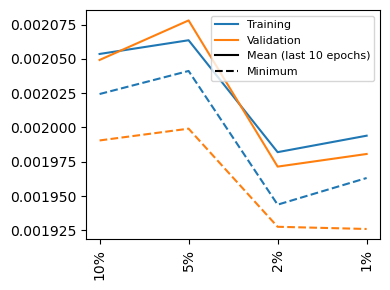

In [4]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(avg_losses, "C0")
ax.plot(min_losses, "--C0")
ax.plot(avg_val_losses, "C1")
ax.plot(min_val_losses, "--C1")

hs = []
legs = ["Training", "Validation", f"Mean (last {n_avg} epochs)", "Minimum"]

hs.append(mpl.lines.Line2D([0], [0], color="C0"))
hs.append(mpl.lines.Line2D([0], [0], color="C1"))
hs.append(mpl.lines.Line2D([0], [0], color="k"))
hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle="--"))

ax.set_xticks(range(len(avg_losses)))
ax.set_xticklabels(labels, rotation=90)

ax.legend(hs, legs, fontsize=8)

fig.tight_layout()
plt.savefig(f"{fig_dir}losses.pdf")

plt.show()
plt.close()

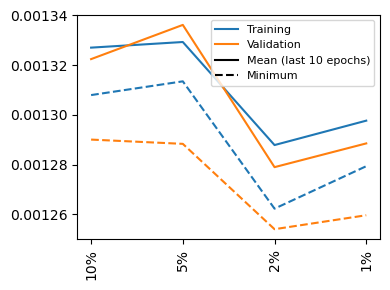

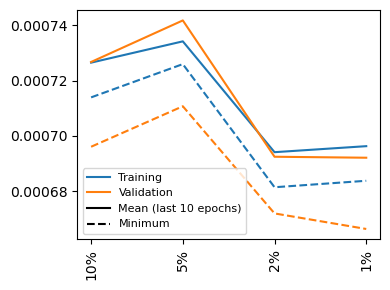

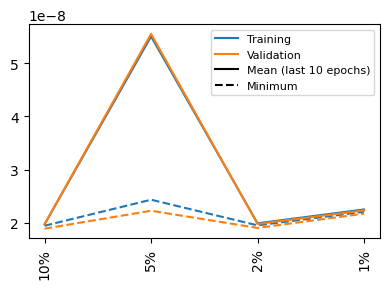

In [5]:
for i in range(avg_loss_components.shape[1]):

    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    ax.plot(avg_loss_components[:, i], "C0")
    ax.plot(min_loss_components[:, i], "--C0")
    ax.plot(avg_val_loss_components[:, i], "C1")
    ax.plot(min_val_loss_components[:, i], "--C1")

    hs = []
    legs = ["Training", "Validation", f"Mean (last {n_avg} epochs)", "Minimum"]

    hs.append(mpl.lines.Line2D([0], [0], color="C0"))
    hs.append(mpl.lines.Line2D([0], [0], color="C1"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))
    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle="--"))

    ax.set_xticks(range(len(avg_losses)))
    ax.set_xticklabels(labels, rotation=90)
    
    ax.legend(hs, legs, fontsize=8)

    fig.tight_layout()
    plt.savefig(f"{fig_dir}loss_component_{i}.pdf")

    plt.show()
    plt.close()